In [1]:
import numpy as np
import sys
import scipy.io as sio  # For reading the matlab .mat format
from scipy.stats import zscore, entropy
from scipy.special import binom as binomial
import collections
import pickle as pk
import itertools
import persim
import numpy as np
import pandas as pd
import iisignature as iis
import gudhi
from gtda.homology import VietorisRipsPersistence
from gtda.homology import FlagserPersistence
import time
import matplotlib.pyplot as plt
import random
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import Amplitude
from gudhi.representations.vector_methods import Entropy

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Load data in .mat format (rows are time instants, columns are ROI, 116 ARE ROIs)
# (THIS IS A SANTORO FUNCTION)
def load_data_mat(path_single_file):
    file_to_open = path_single_file
    data = sio.loadmat(file_to_open)
    key_data = list(data.keys())[-2]
    data = data[key_data]
    return(data)


In [3]:
def lead_matrix_1(mv_time_series):
    N=mv_time_series.shape[1]
    sig=iis.sig(mv_time_series,2)
    S=sig[N:].reshape(N,N)
    L=(S-S.T)/2
    return L
    

In [4]:
def lead_tensor_1(mv_time_series):
    N=mv_time_series.shape[1]
    sig=iis.sig(mv_time_series,3)
    l=N+N*N
    S=sig[l:].reshape(N,N,N)
    T=(S-S.transpose((0,2,1))+S.transpose((2,0,1))-S.transpose((2,1,0))+S.transpose((1,2,0))-S.transpose((1,0,2)))/6
    return T

In [5]:
def rev_directed(L):
    l=L.shape[0]
    a=np.max(np.abs(L))
    for i in range(l):
        for j in range(l):
            if L[j,i]<0:
                L[j,i]=0
                
    ADM=a*np.ones((l,l))-a*np.identity(l)-L            
    dgm=FlagserPersistence().fit_transform([ADM])
    return dgm

In [6]:
def rev_undirected(L):
    l=L.shape[0]
    a=np.max(np.abs(L))
    ADM=a*np.ones((l,l))-a*np.identity(l)-np.abs(L)
    VR= VietorisRipsPersistence(metric="precomputed")
    dgm= VR.fit_transform([ADM])
    return dgm

In [7]:
def fix_violations(list_simplices):
     # Sorting the simplices in a descending order according to weights
    sorted_simplices = sorted(list_simplices, key=lambda x: x[1], reverse=True)

        # Remove the violations
    list_violating_triangles = []
    list_simplices_for_filtration = []
    set_simplices = set()
    counter = 0
    triangles_count = 0
    violation_triangles = 0
    violation_triangles_negativeterms = 0

        # Loop over the sorted simplices, and flippling the sign of all the weights (so that the points in the persistence diagram are above the diagonal)
    for index, i in enumerate(sorted_simplices):
        simplices, weight = i

            # If the current simplex is an edge or a node, then I will immediately include it
        if len(simplices) <= 2:
            list_simplices_for_filtration.append((simplices, -weight))
            set_simplices.add(tuple(simplices))
            counter += 1
        else:
        # If the current simplex is a triplet, I check whether all the sub-simplices have been included.
            flag = 0
            n0=simplices[0]
            n1=simplices[1]        
            n2=simplices[2]
            if (n0,n1) in set_simplices:
                flag=flag+1
            if (n1,n2) in set_simplices:
                flag=flag+1
            if (n0,n2) in set_simplices:
                flag=flag+1

                # If all the sub-simplices already belong to the set, then I add it in the filtration
            if flag == 3:
                set_simplices.add(tuple(simplices))
                list_simplices_for_filtration.append((simplices, -weight))
                counter += 1
                triangles_count += 1
            else:
                violation_triangles += 1
                list_violating_triangles.append((simplices, np.abs(weight), 3 - flag))

# Fraction of positive triangle discarderd (a.k.a. the hyper coherence)
    hyper_coherence = (1.0 * violation_triangles) /(triangles_count + violation_triangles)
    return(list_simplices_for_filtration, list_violating_triangles, hyper_coherence)



In [8]:
def create_filtration(Lead_matrix, Lead_tensor,indifferent_value):
    

    # Creating the list of simplicial complex with all the edges and triangles
    sc=gudhi.SimplexTree()
    list_simplices = []
    N=Lead_matrix.shape[0]
    for i in range(N):
        for j in range(N):
            if np.abs(Lead_matrix[i,j])<indifferent_value:
                Lead_matrix[i,j]=0
            for k in range(N):
                if np.abs(Lead_tensor[i,j,k])<indifferent_value:
                    Lead_tensor[i,j,k]=0

        

        # Selecting the extremal weight between edges and triplets. It will be assigned to all the nodes (i.e. nodes enter at the same instant)
    m_weight = np.max([np.ceil(np.max(np.abs(Lead_matrix))), np.ceil(np.max(np.abs(Lead_tensor)))])
    # Adding all the nodes from the beginning with the same weights
    for i in range(N):
        list_simplices.append(([i], m_weight))

        # Adding the edges:
        # Also, modify the signs of the weights to correct the z-score so that: if the edge signal is fully coherent, then assign a positive sign, otherwise negative
    for i in range(N):
        for j in range(i,N):
            if (not i==j):
                weight=np.abs(Lead_matrix[i,j])
                list_simplices.append(([i,j], weight))

        # Adding the triplets
        # Here I modify the signs of the weights, if it is fully coherent I assign a positive sign, otherwise negative
    for i in range(N):
        for j in range(i,N):
            for k in range(j,N):
                if ((not (i==j)) and (not(j==k)) and (not(i==k))):
                    weight=np.abs(Lead_tensor[i,j,k])
                    list_simplices.append(([i,j,k], weight))

    list_simplices_for_filtration, list_violations, percentage_of_triangles_discarded = fix_violations(list_simplices)
        
    return(list_simplices_for_filtration, list_violations, percentage_of_triangles_discarded)

In [9]:
def create_diagram_matrices(L,T,indifferent_value):
    f=create_filtration(L,T,indifferent_value)
    simpl_list=f[0]
    sc=gudhi.SimplexTree()
    for i in enumerate(simpl_list):
        index,simplices=i
        sc.insert(simplices[0], filtration=simplices[1])
        
    dgm=sc.persistence()
    return dgm

In [10]:
def create_diagram_directly(mv_time_series, indifferent_value):
    L=lead_matrix_1(time_series)
    T=lead_tensor_1(time_series)
    f=create_filtration(L,T,indifferent_value)
    simpl_list=f[0]
    sc=gudhi.SimplexTree()
    for i in enumerate(simpl_list):
        index,simplices=i
        sc.insert(simplices[0], filtration=simplices[1])
        
    dgm=sc.persistence()
    return dgm

In [47]:
# PATH SIGNATURE
Sig=list()
labels=[]
for i in range(1,56):
    if not(i==17):
        time_series=load_data_mat(f"BP_Timeseries/sub{i}_EPI_BPaal_timeseries.mat")
        s=iis.prepare(116,2)
        feat=iis.logsig(time_series,s)
        Sig.append(feat)
        labels.append("BP")
        
for i in range(1,66):
    if not(i==33):
        time_series=load_data_mat(f"HC_Timeseries/sub{i}_EPI_HCaal_timeseries.mat")                                                                                
        s=iis.prepare(116,2)
        feat=iis.logsig(time_series,s)
        Sig.append(feat)
        labels.append("HC")

Feat=np.array(Sig)


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model

In [51]:
X_train, X_test, y_train, y_test=train_test_split(Feat,labels,test_size=0.2)
clf_rf=RandomForestClassifier().fit(X_train,y_train)
y_predicted=clf_rf.predict(X_test)
acc=accuracy_score(y_test,y_predicted)
print(acc)

0.7083333333333334


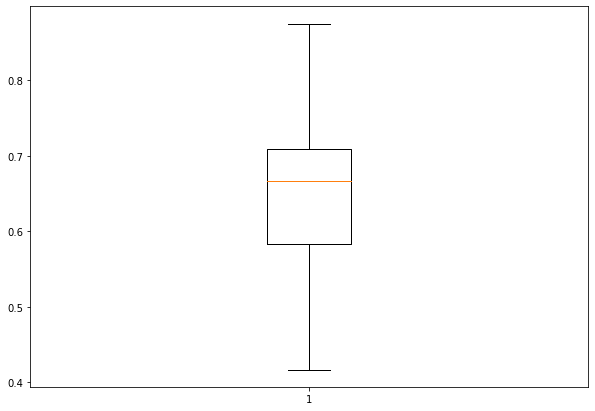

In [14]:
#PLOT OF RANDOM FOREST ACCURACY
acc_values_rf=[]
for i in range(100):
    X_train, X_test, y_train, y_test=train_test_split(Feat,labels,test_size=0.2)
    clf_rf=RandomForestClassifier().fit(X_train,y_train)
    y_predicted=clf_rf.predict(X_test)
    acc=accuracy_score(y_test,y_predicted)
    acc_values_rf.append(acc)

    
    
    
fig = plt.figure(figsize =(10, 7))
 
plt.boxplot(acc_values_rf)
 
plt.show()

In [15]:
# 10 cross validation

sca=StandardScaler()
lr=LogisticRegression()
ppl=Pipeline([('scaler',sca),('clf',lr)])

n_fold=10
cv=KFold(n_fold,shuffle=False)
score_1=cross_val_score(ppl,Feat,labels,cv=cv,n_jobs=-1)
print(score_1)

[0.         0.16666667 0.08333333 0.16666667 0.5        0.5
 0.41666667 0.41666667 0.27272727 0.36363636]


In [72]:
#  LEAD MATRIX
Lead_list=list()
labels=[]
for i in range(1,56):
    if not(i==17):
        time_series=load_data_mat(f"BP_Timeseries/sub{i}_EPI_BPaal_timeseries.mat")[5:175,:]
        L=lead_matrix_1(time_series)
        N=L.shape[0]
        feat=[]
        for j in range(N):
            for k in range(j,N):
                if (not j==k):
                    feat.append(L[j,k])
        Lead_list.append(feat)
        labels.append("BP")
        
for i in range(1,66):
    if not(i==33):
        time_series=load_data_mat(f"HC_Timeseries/sub{i}_EPI_HCaal_timeseries.mat")[5:175,:]
        L=lead_matrix_1(time_series)
        N=L.shape[0]
        feat=[]
        for j in range(N):
            for k in range(j,N):
                if (not j==k):
                    feat.append(L[j,k])
        Lead_list.append(feat)
        labels.append("HC")

LEAD=np.array(Lead_list)


In [73]:
X_train, X_test, y_train, y_test=train_test_split(LEAD,labels,test_size=0.2)
clf_rf=RandomForestClassifier().fit(X_train,y_train)
y_predicted=clf_rf.predict(X_test)
acc=accuracy_score(y_test,y_predicted)
print(acc)

0.625


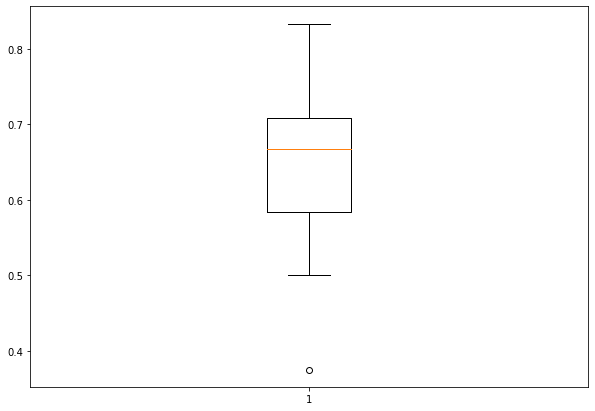

In [74]:
#PLOT OF RANDOM FOREST ACCURACY
acc_values=[]
for i in range(100):
    X_train, X_test, y_train, y_test=train_test_split(LEAD,labels,test_size=0.2)
    clf_rf=RandomForestClassifier().fit(X_train,y_train)
    y_predicted=clf_rf.predict(X_test)
    acc=accuracy_score(y_test,y_predicted)
    acc_values.append(acc)

    
    
    
fig = plt.figure(figsize =(10, 7))
 
plt.boxplot(acc_values)
 
plt.show()

In [75]:
# cross validation
sca=StandardScaler()
lr=LogisticRegression()
ppl=Pipeline([('scaler',sca),('clf',lr)])

n_fold=10
cv=KFold(n_fold,shuffle=False)
score_1=cross_val_score(ppl,LEAD,labels,cv=cv,n_jobs=-1)
print(score_1)

[0.         0.         0.         0.         0.5        0.
 0.         0.08333333 0.09090909 0.        ]


In [20]:
#  CLIQUE COMPLEX DIRECTED
topological_clique_list=list()
labels=[]
for i in range(1,56):
    if not(i==17):
        time_series=load_data_mat(f"BP_Timeseries/sub{i}_EPI_BPaal_timeseries.mat")[10:170,:]
        L=lead_matrix_1(time_series)
        dgm_clique=rev_directed(L)
        PE = PersistenceEntropy()
        pe_feat = PE.fit_transform(dgm_clique)
        A=Amplitude()
        ampl_feat=A.fit_transform(dgm_clique)
        feat1=pe_feat.flatten()
        feat2=ampl_feat.flatten()
        feat=np.concatenate((feat1,feat2), axis=0)
        topological_clique_list.append(feat)
        labels.append("BP")
        
for i in range(1,66):
    if not(i==33):
        time_series=load_data_mat(f"HC_Timeseries/sub{i}_EPI_HCaal_timeseries.mat")[10:170,:]
        L=lead_matrix_1(time_series)
        dgm_clique=rev_directed(L)
        PE = PersistenceEntropy()
        pe_feat = PE.fit_transform(dgm_clique)
        A=Amplitude()
        ampl_feat=A.fit_transform(dgm_clique)
        feat1=pe_feat.flatten()
        feat2=ampl_feat.flatten()
        feat=np.concatenate((feat1,feat2), axis=0)
        topological_clique_list.append(feat)
        labels.append("HC")

topological_clique_array=np.array(topological_clique_list)

In [21]:
X_train, X_test, y_train, y_test=train_test_split(topological_clique_array,labels,test_size=0.2)
clf_rf=RandomForestClassifier().fit(X_train,y_train)
y_predicted=clf_rf.predict(X_test)
acc=accuracy_score(y_test,y_predicted)
print(acc)

0.5897435897435898


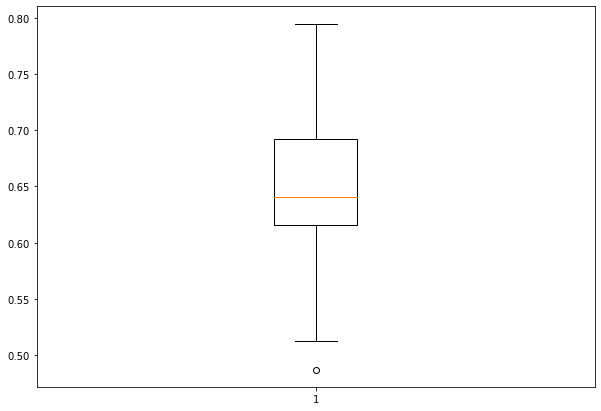

In [22]:
# PLOT RANDOM FOREST
acc_values=[]
for i in range(100):
    X_train, X_test, y_train, y_test=train_test_split(topological_clique_array,labels,test_size=0.2)
    clf_rf=RandomForestClassifier().fit(X_train,y_train)
    y_predicted=clf_rf.predict(X_test)
    acc=accuracy_score(y_test,y_predicted)
    acc_values.append(acc)

    
    
    
fig = plt.figure(figsize =(10, 7))
 
plt.boxplot(acc_values)
 
plt.show()

In [23]:
# cross validation
sca=StandardScaler()
lr=LogisticRegression()
ppl=Pipeline([('scaler',sca),('clf',lr)])

n_fold=10
cv=KFold(n_fold,shuffle=False)
score_1=cross_val_score(ppl,topological_clique_array,labels,cv=cv,n_jobs=-1)
print(score_1)

[0.         0.         0.         0.         0.41666667 0.33333333
 0.41666667 0.33333333 0.27272727 0.27272727]


In [24]:
#  CLIQUE COMPLEX UNDIRECTED
topological_clique_undirected_list=list()
labels=[]
for i in range(1,56):
    if not(i==17):
        time_series=load_data_mat(f"BP_Timeseries/sub{i}_EPI_BPaal_timeseries.mat")[10:170,:]
        L=lead_matrix_1(time_series)
        dgm_clique=rev_undirected(L)
        PE = PersistenceEntropy()
        pe_feat = PE.fit_transform(dgm_clique)
        A=Amplitude()
        ampl_feat=A.fit_transform(dgm_clique)
        feat1=pe_feat.flatten()
        feat2=ampl_feat.flatten()
        feat=np.concatenate((feat1,feat2), axis=0)
        topological_clique_undirected_list.append(feat)
        labels.append("BP")
        
for i in range(1,66):
    if not(i==33):
        time_series=load_data_mat(f"HC_Timeseries/sub{i}_EPI_HCaal_timeseries.mat")[10:170,:]
        L=lead_matrix_1(time_series)
        dgm_clique=rev_undirected(L)
        PE = PersistenceEntropy()
        pe_feat = PE.fit_transform(dgm_clique)
        A=Amplitude()
        ampl_feat=A.fit_transform(dgm_clique)
        feat1=pe_feat.flatten()
        feat2=ampl_feat.flatten()
        feat=np.concatenate((feat1,feat2), axis=0)
        topological_clique_undirected_list.append(feat)
        labels.append("HC")

topological_clique_undirected_array=np.array(topological_clique_undirected_list)

In [25]:
X_train, X_test, y_train, y_test=train_test_split(topological_clique_undirected_array,labels,test_size=0.2)
clf_rf=RandomForestClassifier().fit(X_train,y_train)
y_predicted=clf_rf.predict(X_test)
acc=accuracy_score(y_test,y_predicted)
print(acc)

0.6666666666666666


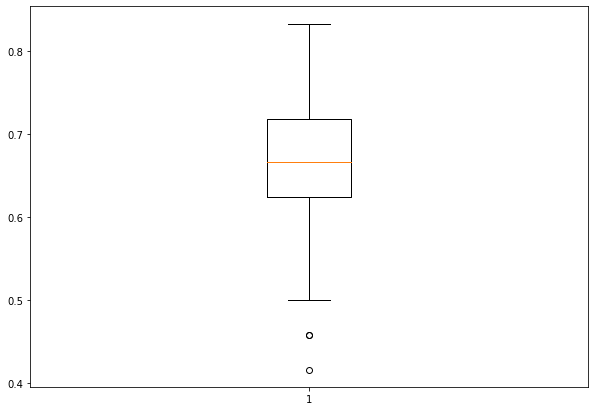

In [26]:
#PLOT OF RANDOM FOREST ACCURACY
acc_values=[]
for i in range(100):
    X_train, X_test, y_train, y_test=train_test_split(topological_clique_undirected_array,labels,test_size=0.2)
    clf_rf=RandomForestClassifier().fit(X_train,y_train)
    y_predicted=clf_rf.predict(X_test)
    acc=accuracy_score(y_test,y_predicted)
    acc_values.append(acc)

    
    
    
fig = plt.figure(figsize =(10, 7))
 
plt.boxplot(acc_values)
 
plt.show()

In [27]:
# cross validation

sca=StandardScaler()
lr=LogisticRegression()
ppl=Pipeline([('scaler',sca),('clf',lr)])

n_fold=10
cv=KFold(n_fold,shuffle=False)
score_1=cross_val_score(ppl,topological_clique_undirected_array,labels,cv=cv,n_jobs=-1)
print(score_1)

[0.         0.33333333 0.08333333 0.16666667 0.58333333 0.5
 0.58333333 0.41666667 0.72727273 0.54545455]


In [28]:
topological_clique_undirected_array.shape

(118, 4)

In [29]:
# HYPERCOHERENCE
Hyp_coh_list=list()
labels=[]
for i in range(1,56):
    if not(i==17):
        time_series=load_data_mat(f"BP_Timeseries/sub{i}_EPI_BPaal_timeseries.mat")
        L=lead_matrix_1(time_series)
        T=lead_tensor_1(time_series)
        f=create_filtration(L,T,0)
        hyp=f[2]
        Hyp_coh_list.append(hyp)
        labels.append("BP")
        
for i in range(1,66):
    if not(i==33):
        time_series=load_data_mat(f"HC_Timeseries/sub{i}_EPI_HCaal_timeseries.mat")
        L=lead_matrix_1(time_series)
        T=lead_tensor_1(time_series)
        f=create_filtration(L,T,0)
        hyp=f[2]
        Hyp_coh_list.append(hyp)
        labels.append("HC")


In [30]:
Hyp_coh_array=np.array(Hyp_coh_list)

In [31]:
HYP=Hyp_coh_array.reshape(-1,1)

In [32]:
X_train, X_test, y_train, y_test=train_test_split(HYP,labels,test_size=0.2)
clf=RandomForestClassifier().fit(X_train,y_train)
y_predicted=clf.predict(X_test)
acc=accuracy_score(y_test,y_predicted)
print(acc)

0.625


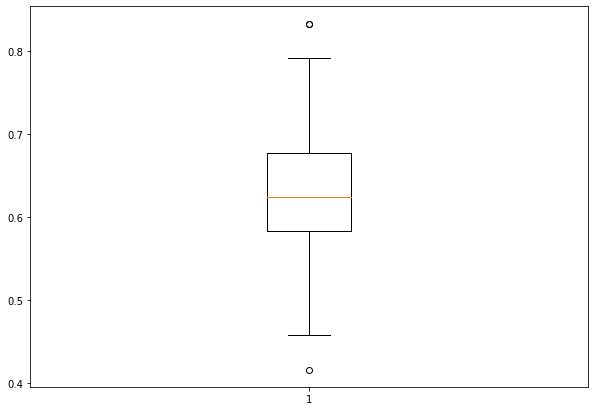

In [33]:
#PLOT OF RANDOM FOREST ACCURACY
acc_values=[]
for i in range(100):
    X_train, X_test, y_train, y_test=train_test_split(HYP,labels,test_size=0.2)
    clf=RandomForestClassifier().fit(X_train,y_train)
    y_predicted=clf.predict(X_test)
    acc=accuracy_score(y_test,y_predicted)
    acc_values.append(acc)

    
    
    
fig = plt.figure(figsize =(10, 7))
 
plt.boxplot(acc_values)
 
plt.show()

In [34]:
# cross validation
sca=StandardScaler()
lr=LogisticRegression()
ppl=Pipeline([('scaler',sca),('clf',lr)])

n_fold=10
cv=KFold(n_fold,shuffle=False)
score_1=cross_val_score(ppl,HYP,labels,cv=cv,n_jobs=-1)
print(score_1)

[0.08333333 0.16666667 0.25       0.16666667 0.5        0.66666667
 0.66666667 0.75       0.63636364 0.63636364]


In [37]:
# SIMPLICIAL COMPLEX HIGH ( still figuring out how to get entropy with gudhi)



#High_lead=list()
#labels=[]
#for i in range(1,56):
    #if not(i==17):
        #time_series=load_data_mat(f"BP_Timeseries/sub{i}_EPI_BPaal_timeseries.mat")
        #dgm=create_diagram_directly(time_series,0)
        
        #labels.append("BP")
        
#for i in range(1,66):
    #if not(i==33):
        #time_series=load_data_mat(f"HC_Timeseries/sub{i}_EPI_HCaal_timeseries.mat")
        
        #labels.append("HC")


In [38]:
# trying to compute stuff


#time_series=load_data_mat("BP_Timeseries/sub10_EPI_BPaal_timeseries.mat")
#dgm=create_diagram_directly(time_series,0)

In [39]:
# still figuring out how to do


#en=Entropy()
#fen=en.__call__(dgm)
#entr=en.transform(fen)

In [41]:
#entropy=Entropy.transform([dgm],y=None)